In [1]:
# Procesado de datos
# ==============================================================================
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
#from skforecast.plot import set_dark_theme
#set_dark_theme()
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Tensorflow and Keras
# ==============================================================================
import tensorflow
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.losses import MeanSquaredError # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

# Modelado series temporales
# ==============================================================================
import skforecast
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print(f"skforecast version: {skforecast.__version__}")
print(f"tensorflow version: {tensorflow.__version__}")


skforecast version: 0.12.1
tensorflow version: 2.16.2


c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
# Descarga y procesado de datos
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia")

air_quality_valencia
--------------------
Hourly measures of several air quimical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26304, 10)


In [3]:
# Imputación de datos ausentes mediante interpolación lineal
# ==============================================================================
air_quality = air_quality.interpolate(method="linear")
air_quality = air_quality.sort_index()
air_quality.head()

,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,8.0
2019-01-01 01:00:00,26.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,8.0
2019-01-01 02:00:00,31.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,8.0
2019-01-01 03:00:00,30.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,10.0
2019-01-01 04:00:00,30.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,11.0


In [4]:
# Comprobación de índice y frecuencia
# ==============================================================================
print(f"Tipo de índice: {air_quality.index.dtype}")
print(f"Frecuencia: {air_quality.index.freq}")

Tipo de índice: datetime64[ns]
Frecuencia: <Hour>


In [5]:
plt.style.use(['seaborn-v0_8-darkgrid'])


In [6]:
# Split train-validation-test
# ==============================================================================
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Fechas train      : {air_quality_train.index.min()} --- " 
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Fechas validation : {air_quality_val.index.min()} --- " 
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Fechas test       : {air_quality_test.index.min()} --- " 
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Fechas train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Fechas validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Fechas test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


Text(0, 0.5, 'µg/m³')

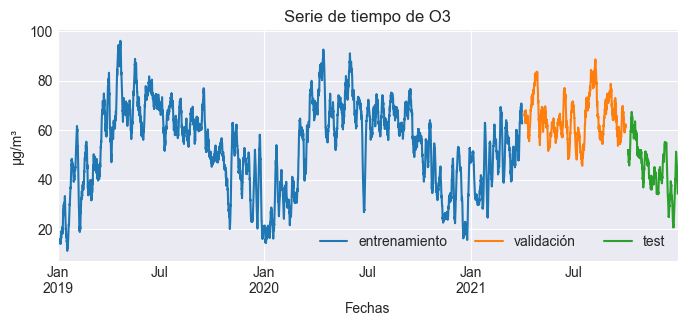

In [7]:
# Gráfico de la serie temporal del contaminante pm2.5
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
air_quality_train["o3"].rolling(100).mean().plot(ax=ax, label="entrenamiento")
air_quality_val["o3"].rolling(100).mean().plot(ax=ax, label="validación")
air_quality_test["o3"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("Serie de tiempo de O3")
ax.legend(loc='lower right',ncol=3)
plt.xlabel("Fechas")   
plt.ylabel("µg/m³")

## Modelo LTSM Y ForecasterRnn

In [8]:
# Creación del modelo
# ==============================================================================
series = ["o3"] # Series temporales que se utilizarán para entrenar el modelo.
levels = ["o3"] # Serie que se quiere predecir
lags = 32 # Valores pasados a utilizar en la predicción
steps = 1 # Pasos a futuro a predecir

# Selección de las series temporales utilizadas
data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Creación del forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Número de épocas para entrenar el modelo.
        "batch_size": 32,  # Tamaño del batch para entrenar el modelo.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)
forecaster

AttributeError: 'InputLayer' object has no attribute 'input_shape'

In [ ]:
# Entrenamiento del forecaster
# ==============================================================================
forecaster.fit(data_train)

NameError: name 'forecaster' is not defined

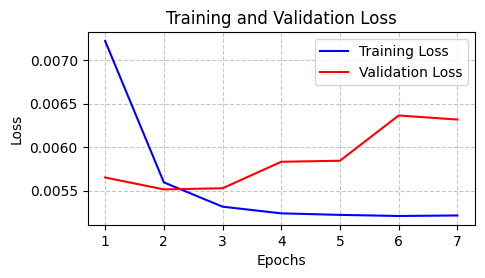

In [ ]:
# Seguimiento del entrenamiento y overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)

In [ ]:
# Predicción
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01,44.044189


In [ ]:
# Backtesting con datos de test
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

tensorflow WARNING Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Epoch 1/10
752/752 [==============================] - 52s 68ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 2/10
752/752 [==============================] - 49s 66ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 3/10
752/752 [==============================] - 47s 62ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 4/10
752/752 [==============================] - 42s 56ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 5/10
752/752 [==============================] - 36s 48ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 6/10
752/752 [==============================] - 40s 53ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 7/10
752/752 [==============================] - 44s 59ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 8/10
752/752 [==============================] - 55s 73ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 9/10
752/752 [==============================] - 43s 57ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 10/10
752/752 [==============================] - 41s 54ms/step - loss: 0.005

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2208/2208 [04:37<00:00,  7.96it/s]


In [ ]:
# Predicciones de backtesting
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,52.442066
2021-10-01 01:00:00,57.599495
2021-10-01 02:00:00,60.825691
2021-10-01 03:00:00,61.387489
2021-10-01 04:00:00,52.096485
...,...
2021-12-31 19:00:00,15.319837
2021-12-31 20:00:00,12.457646
2021-12-31 21:00:00,14.847246
2021-12-31 22:00:00,14.771048


In [ ]:
# Gráfico de las predicciones vs valores reales en el conjunto de test
# ==============================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['o3'], name="predicciones", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicciones vs valores reales en el conjunto de test",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="left",
        x=0
    )
)
fig.show()

NameError: name 'data_test' is not defined

In [ ]:
# Métricas de backtesting
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,5.732502


In [ ]:
# Error en % respecto a la media de la serie
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Media de la serie: {np.mean(data['o3']):0.2f}")
print(f"Error (mae) relativo: {rel_mse:0.2f} %")

Media de la serie: 54.52
Error (mae) relativo: 10.51 %


In [ ]:
# Creación del modelo
# ==============================================================================
series = ["o3"] # Series temporales que se utilizarán para entrenar el modelo. 
levels = ["o3"] # Serie que se quiere predecir
lags = 32 # Valores pasados a utilizar en la predicción
steps = 5 # Pasos a futuro a predecir

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=50,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

tensorflow WARNING Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 32)                1632      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
 reshape_1 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 12197 (47.64 KB)
Trainable params: 12197 (47.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Creación del Forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Número de épocas para entrenar el modelo.
        "batch_size": 32,  # Tamaño del batch para entrenar el modelo.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)

In [ ]:
# Entrenamiento del forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
615/615 [==============================] - 75s 119ms/step - loss: 0.0212 - val_loss: 0.0135
Epoch 2/10
615/615 [==============================] - 75s 121ms/step - loss: 0.0136 - val_loss: 0.0121
Epoch 3/10
615/615 [==============================] - 92s 150ms/step - loss: 0.0129 - val_loss: 0.0117
Epoch 4/10
615/615 [==============================] - 79s 128ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 5/10
615/615 [==============================] - 85s 138ms/step - loss: 0.0122 - val_loss: 0.0124
Epoch 6/10
615/615 [==============================] - 82s 133ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 7/10
615/615 [==============================] - 72s 117ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 8/10
615/615 [==============================] - 71s 115ms/step - loss: 0.0117 - val_loss: 0.0123


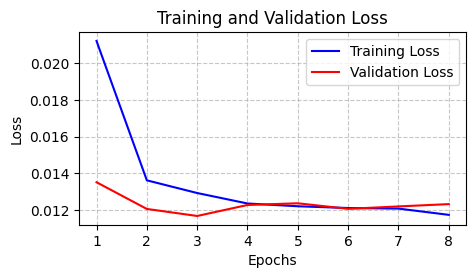

In [ ]:
# Seguimiento del entrenamiento y overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)